# I Gaussian Process Regression

In [27]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

We define a function `man_ExpSquaredKernel(t, A=1.0, l=1.0)` that returns the covariance matrix described by the squared exponential kernel for two arrays of times `t1` and `t2`. (We can also use it as `from george.kernels import ExpSquaredKernel`, where, the *metric* parameter in `ExpSquaredKernel` represents $2.l^2$ (where $l$ is the length scale))

In [2]:
def man_ExpSquaredKernel(t1, t2=None, A=1.0, l=1.0):
    if t2 is None:
        t2 = t1
    T2, T1 = np.meshgrid(t2, t1)
    return A ** 2 * np.exp(-0.5 * (T1-T2)**2 / l**2)

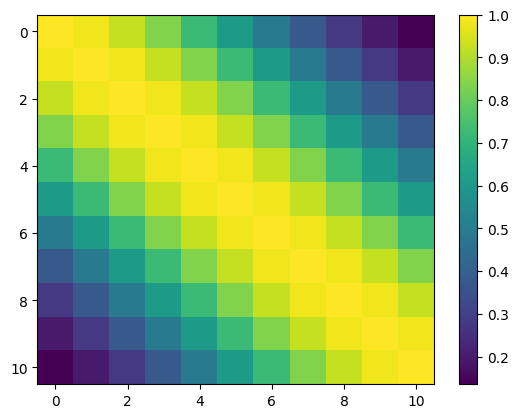

In [3]:
# Visual representation of the Kernel Matrix
t = np.linspace(0,2,11)
S = man_ExpSquaredKernel(t)
plt.imshow(S, interpolation='nearest',aspect='auto')
plt.colorbar();

To draw samples from a multivariate Gaussian given its mean vector `mu` and its covariance matrix `S`, we can use `np.random.multivariate_normal`.

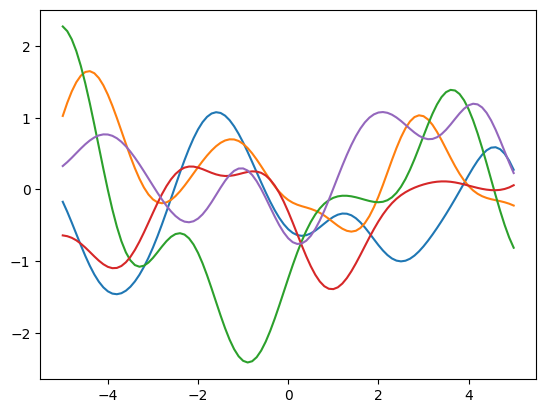

In [31]:
np.random.seed(42)

t = np.linspace(-5,5,101)
mu = np.zeros_like(t)
S = man_ExpSquaredKernel(t)
samples = np.random.multivariate_normal(mu, S, 5)
plt.plot(t,samples.T);

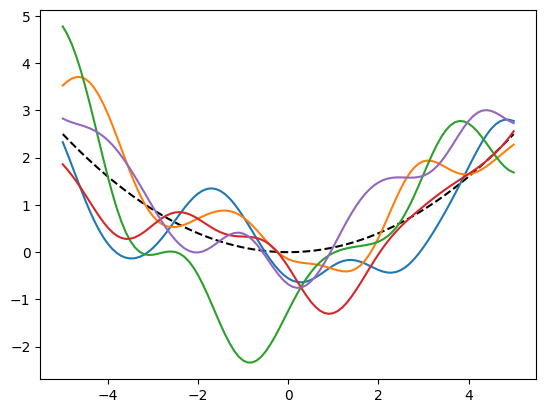

In [32]:
np.random.seed(42)

# Introduced a non-trivial mean vector
mu = 0.1 * t**2
plt.plot(t,mu,'k--')
samples = np.random.multivariate_normal(mu, S, 5)
plt.plot(t,samples.T);

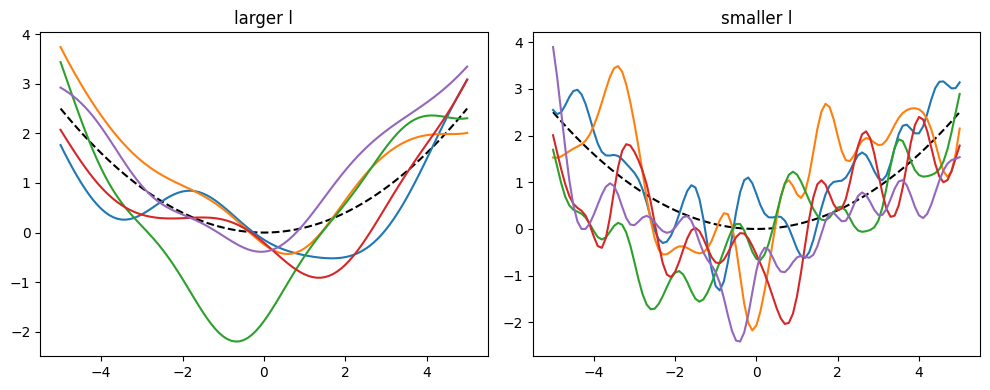

In [47]:
np.random.seed(42)

mu = 0.1 * t**2
S1 = man_ExpSquaredKernel(t, l = 1.6)
S2 = man_ExpSquaredKernel(t, l = 0.4)
samples1 = np.random.multivariate_normal(mu, S1, 5)
samples2 = np.random.multivariate_normal(mu, S2, 5)

fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(10, 4))

plot1.plot(t, mu, 'k--')
plot1.plot(t, samples1.T)
plot1.set_title("larger l")

plot2.plot(t, mu, 'k--')
plot2.plot(t, samples2.T)
plot2.set_title("smaller l")

plt.tight_layout()
plt.show()

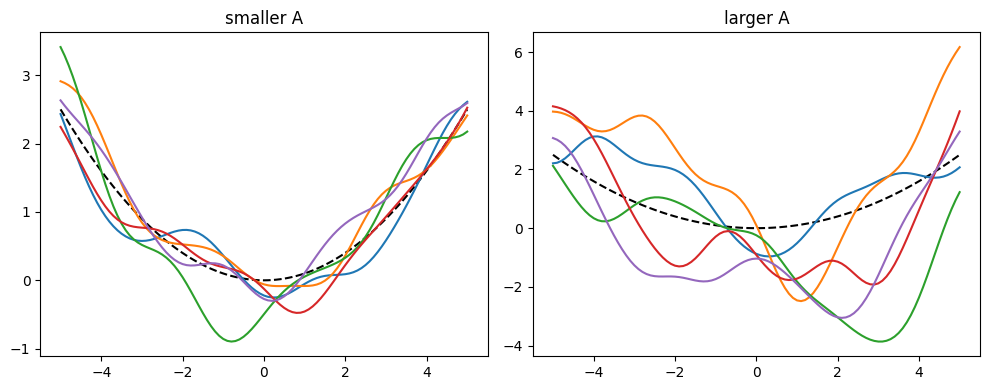

In [46]:
np.random.seed(42)

mu = 0.1 * t**2
S3 = man_ExpSquaredKernel(t, A = 0.4)
S4 = man_ExpSquaredKernel(t, A = 1.6)
samples3 = np.random.multivariate_normal(mu, S3, 5)
samples4 = np.random.multivariate_normal(mu, S4, 5)

fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(10, 4))

plot1.plot(t, mu, 'k--')
plot1.plot(t, samples3.T)
plot1.set_title("smaller A")

plot2.plot(t, mu, 'k--')
plot2.plot(t, samples4.T)
plot2.set_title("larger A")

plt.tight_layout()
plt.show()

### Conditioning GP on some prior data

We showcase this on an exemplar `t_train` data randomly generated

Next, we define a function `compute_gp` that evaluates the mean vector `mu` and covariance matrix `S` of the GP evaluated at training points `t_test` given some data (`t_train`, `y_train`).

In [7]:
def compute_gp(t_train, y_train, t_test, kernel = man_ExpSquaredKernel, **kwargs):
    # Compute the required matrices
    Stt = kernel(t_train, **kwargs)
    Spp = kernel(t_test, **kwargs)
    Spt = kernel(t_test, t_train, **kwargs)

    # Compute the mean and covariance of the GP
    mu = np.dot(Spt, np.linalg.solve(Stt, y_train))
    S = Spp - np.dot(Spt, np.linalg.solve(Stt, Spt.T))

    return mu, S

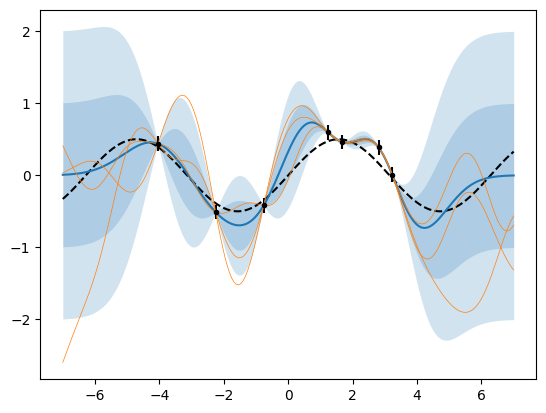

In [8]:
t_train = np.random.uniform(-5,5,7) # len =7
wn = 0.1
y_train = 0.5 * np.sin(t_train) + np.random.normal(0, 1, len(t_train)) * wn
plt.errorbar(t_train, y_train, yerr = wn, fmt='k.', capsize=0)
t_test = np.linspace(-7, 7, 201)
y_true = 0.5 * np.sin(t_test)
plt.plot(t_test, y_true, 'k--')
gp_mu, gp_S = compute_gp(t_train, y_train, t_test)
sig = np.sqrt(gp_S.diagonal())
plt.plot(t_test, gp_mu, color="C0")
plt.fill_between(t_test, gp_mu - sig, gp_mu + sig, color="C0", alpha=0.2,lw=0);
plt.fill_between(t_test, gp_mu - 2 * sig, gp_mu + 2 * sig, color="C0", alpha=0.2,lw=0);
samples = np.random.multivariate_normal(gp_mu, gp_S,3)
plt.plot(t_test, samples.T, color="C1", lw=0.5);

Next, we define the negative log likelihood (`nll`) function of the GP

In [11]:
def nll_gp(p, t, y, sigma):
    A, l = np.exp(p)
    npts = len(t)
    K = man_ExpSquaredKernel(t, A = A, l=l) + sigma ** 2 * np.eye(npts)
    nll = 0.5 * np.dot(y.T, np.linalg.solve(K, y))
    nll += 0.5 * np.linalg.slogdet(K)[1]
    nll += 0.5 * npts * np.log(2 * np.pi)
    return nll

[1. 1.] 5.380863128783793
[0.42382771 0.77467689] 3.0736682782877924


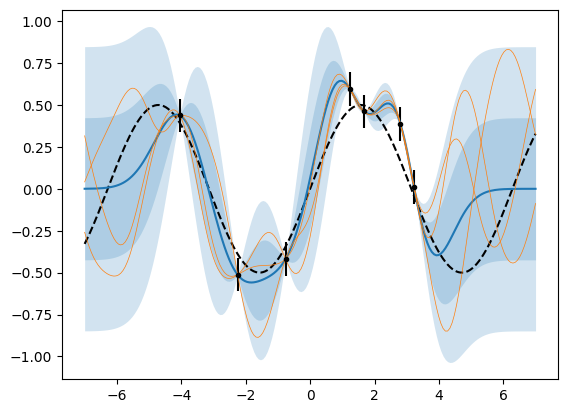

In [13]:
from scipy.optimize import minimize 
p0 = np.array([0.0, 0.0])

print(np.exp(p0),nll_gp(p0,t_train,y_train,wn))
res = minimize(nll_gp, p0, args = (t_train, y_train, wn))
ml_par = res.x
print(np.exp(ml_par), res.fun)

plt.errorbar(t_train, y_train, yerr = wn, fmt='k.', capsize=0)
plt.plot(t_test, y_true, 'k--')
gp_mu, gp_S = compute_gp(t_train, y_train, t_test, A = np.exp(ml_par[0]), l = np.exp(ml_par[1]))
sig = np.sqrt(gp_S.diagonal())
plt.plot(t_test, gp_mu, color="C0")
plt.fill_between(t_test, gp_mu - sig, gp_mu + sig, color="C0", alpha=0.2,lw=0);
plt.fill_between(t_test, gp_mu - 2 * sig, gp_mu + 2 * sig, color="C0", alpha=0.2,lw=0);
samples = np.random.multivariate_normal(gp_mu, gp_S,3)
plt.plot(t_test, samples.T, color="C1", lw=0.5);

# II Simulating a noisy light curve with Sinusoidal and Gaussian waves

In [4]:
# Imports and seed
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

# Exponentiated Squared (RBF) Kernel
def ExpSquaredKernel(t1, t2=None, A=1.0, l=1.0):
    if t2 is None:
        t2 = t1
    T2, T1 = np.meshgrid(t2, t1)
    return A**2 * np.exp(-0.5 * (T1 - T2)**2 / l**2)

## Simulating a Sinusoidal Signal (e.g., stellar pulsation)

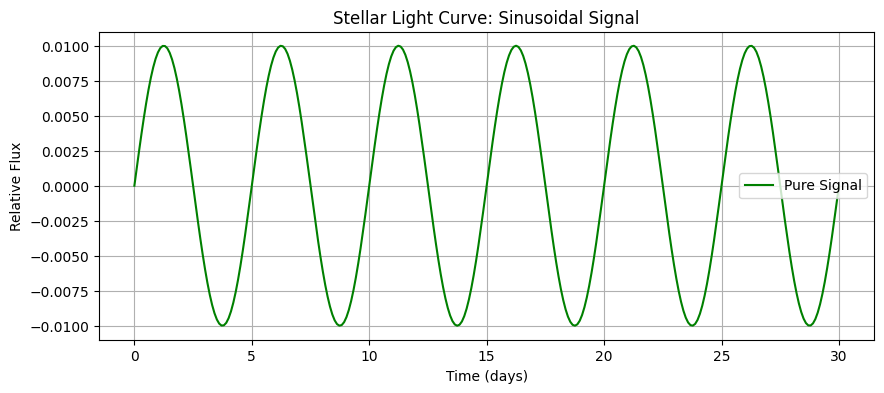

In [3]:
# Time array (e.g., 30 days sampled every 0.1 days)
t = np.linspace(0, 30, 300)

period = 5  # days
amplitude = 0.01  # relative flux
signal = amplitude * np.sin(2 * np.pi * t / period)

plt.figure(figsize=(10, 4))
plt.plot(t, signal, label="Pure Signal", color='green')
plt.xlabel("Time (days)")
plt.ylabel("Relative Flux")
plt.title("Stellar Light Curve: Sinusoidal Signal")
plt.legend()
plt.grid(True)
plt.show()


## Simulating a GP Noise

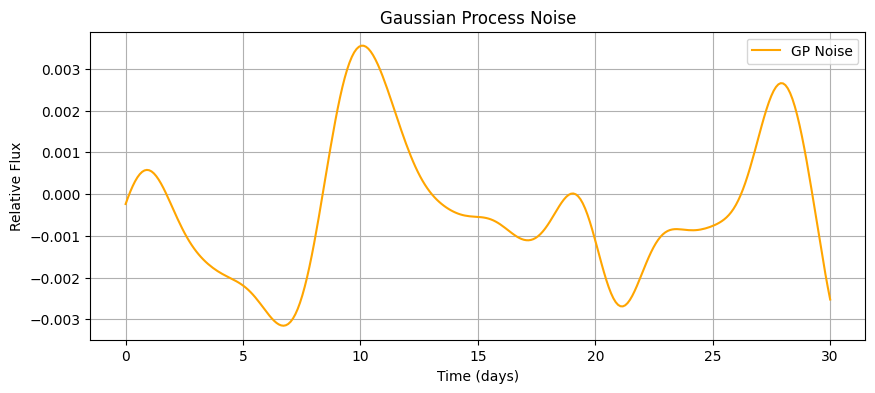

In [5]:
# Parameters: amplitude A and length scale l of the GP kernel
A_gp = 0.002  # smaller than signal amplitude
l_gp = 1.5    # correlation length scale

# Covariance matrix
cov = ExpSquaredKernel(t, A=A_gp, l=l_gp)

# Sample from the multivariate normal
noise = np.random.multivariate_normal(mean=np.zeros(len(t)), cov=cov)

plt.figure(figsize=(10, 4))
plt.plot(t, noise, label="GP Noise", color='orange')
plt.xlabel("Time (days)")
plt.ylabel("Relative Flux")
plt.title("Gaussian Process Noise")
plt.legend()
plt.grid(True)
plt.show()

## Combining the two curves to simulate a Noisy Stellar Light Curve

We also add a `white_noise` to further simulate real signal capture. Here, the White Noise follows a Normal Distribution with variance $\sigma ^2$. Mathematically speaking,
`white_noise` ~ $N(0, \sigma ^2)$

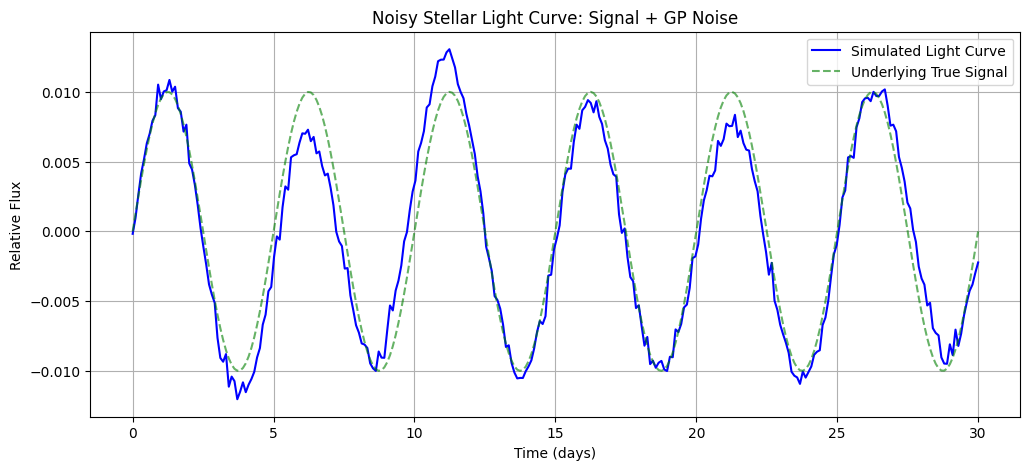

In [11]:
sigma = 0.0005
white_noise = np.random.normal(0, sigma, size=t.shape)

lightcurve = signal + noise + white_noise

plt.figure(figsize=(12, 5))
plt.plot(t, lightcurve, label="Simulated Light Curve", color='blue')
plt.plot(t, signal, label="Underlying True Signal", color='green', alpha=0.6, linestyle='--')
plt.xlabel("Time (days)")
plt.ylabel("Relative Flux")
plt.title("Noisy Stellar Light Curve: Signal + GP Noise")
plt.legend()
plt.grid(True)
plt.show()


# III Stellar light curves from the Keplar Mission

The Kepler mission measured the brightnesses in the visible band of ∼150,000 stars every 29.4 minutes for nearly 4 years with very high precision. The mission successfully detected several thousand cases where an exoplanet transited across the stellar disk, causing faint periodic dips. But the effort was complicated by the wide range in intrinsic stellar variability. We illustrate some time series methods for evenly spaced time series using two stars that have been preprocessed using the procedures of Caceres et al. (2019). One star exhibits low level stochastic scatter characteristics of solar-type stars with low magnetic activity, and the other shows high levels of quasi-periodic variability from rotationally modulated starspots. We do not attempt to detect transiting exoplanets in this tutorial.

The **first** Kepler lightcurve `KIC 007596240`. The input data here is a vector of 71,427 evenly spaced flux measurements of which 16% are missing (NAs). The median is close to zero and the interquartile range is 6.5 flux units.<br>
The **second** Kepler lightcurve `(KIC 007609553)` shows high amplitude variability that is attributed to stellar rotation where the starlight is modulated as dark starspots rotate in and out of view. In simple words,<br>
`Kepler1.dat` → *quiet star* data <br>
`Kepler2.dat` → *rotation star* data

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data (handle NA safely) and save memory using float32
flux1 = np.genfromtxt("Kepler1.dat", dtype=np.float32, missing_values="NA", filling_values=np.nan)
flux2 = np.genfromtxt("Kepler2.dat", dtype=np.float32, missing_values="NA", filling_values=np.nan)

# Count missing values
n_missing_flux1 = np.isnan(flux1).sum()
n_missing_flux2 = np.isnan(flux2).sum()
n_total_flux1 = len(flux1)
n_total_flux2 = len(flux2)
print(f"Kepler1: {n_missing_flux1}/{n_total_flux1} ({100 * n_missing_flux1 / n_total_flux1:.2f}% missing)")
print(f"kepler2: {n_missing_flux2}/{n_total_flux2} ({100 * n_missing_flux2 / n_total_flux2:.2f}% missing)")

Kepler1: 11337/71427 (15.87% missing)
kepler2: 20598/71427 (28.84% missing)


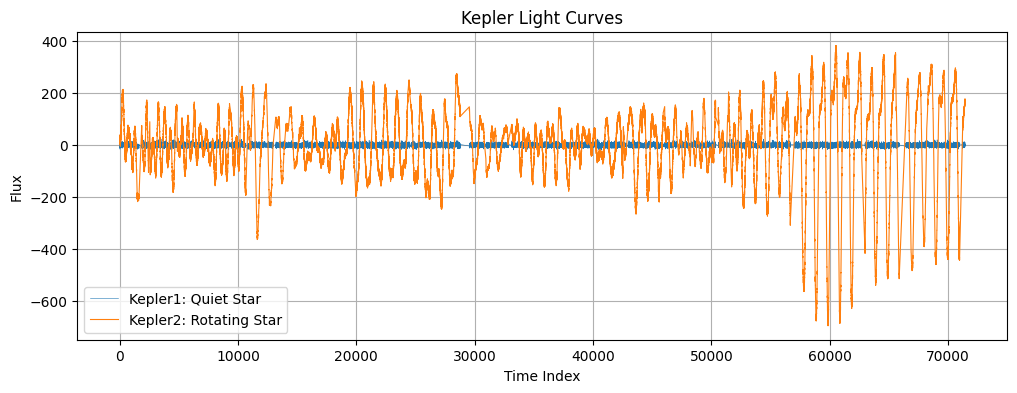

In [64]:
# Masked plots to ignore NaNs
t1 = np.arange(len(flux1))
t2 = np.arange(len(flux2))

plt.figure(figsize=(12, 4))
plt.plot(t1[~np.isnan(flux1)], flux1[~np.isnan(flux1)], lw=0.4, label='Kepler1: Quiet Star')
plt.plot(t2[~np.isnan(flux2)], flux2[~np.isnan(flux2)], lw=0.8, label='Kepler2: Rotating Star')
plt.xlabel("Time Index")
plt.ylabel("Flux")
plt.legend()
plt.title("Kepler Light Curves")
plt.grid(True)
plt.show()

In [88]:
from scipy.interpolate import interp1d

# Only use valid indices
valid1 = ~np.isnan(flux1)
interp_func1 = interp1d(t1[valid1], flux1[valid1], kind='linear', fill_value="extrapolate")
flux1_interp = interp_func1(t1)

valid2 = ~np.isnan(flux2)
interp_func2 = interp1d(t2[valid2], flux2[valid2], kind = 'linear', fill_value = 'extrapolate')
flux2_interp = interp_func2(t2)

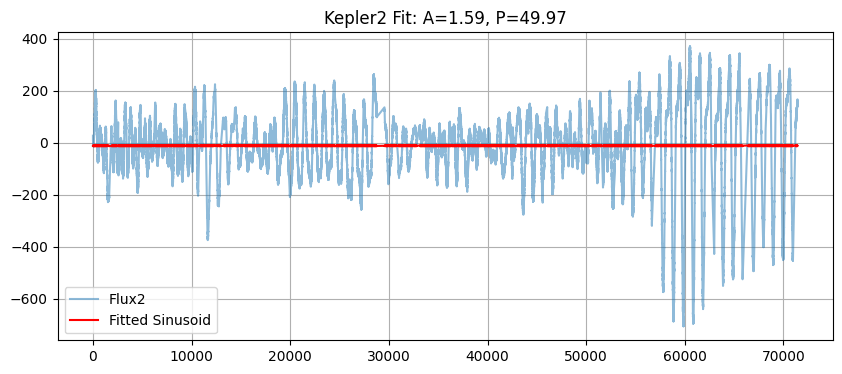

In [66]:
from scipy.optimize import curve_fit

def sinusoid(t, A, P, phi, offset):
    return A * np.sin(2 * np.pi * t / P + phi) + offset

# Use only finite values
finite = ~np.isnan(flux2)
t_fit = t2[finite]
f_fit = flux2[finite] - np.nanmedian(flux2)

# Initial guesses: A=10, P=50, phi=0, offset=0
popt, _ = curve_fit(sinusoid, t_fit, f_fit, p0=[10, 50, 0, 0])
A, P, phi, offset = popt

# Reconstruct fitted signal
fitted = sinusoid(t_fit, *popt)

plt.figure(figsize=(10, 4))
plt.plot(t_fit, f_fit, label='Flux2', alpha=0.5)
plt.plot(t_fit, fitted, label='Fitted Sinusoid', color='r')
plt.legend()
plt.title(f"Kepler2 Fit: A={A:.2f}, P={P:.2f}")
plt.grid(True)
plt.show()

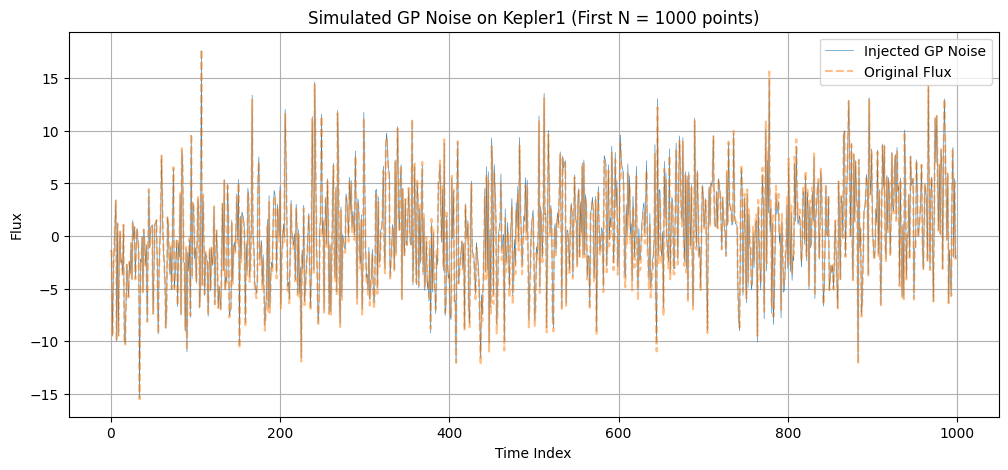

In [94]:
np.random.seed(442)

def man_ExpSquaredKernel(t1, t2=None, A=1.0, l=1.0):
    if t2 is None:
        t2 = t1
    T2, T1 = np.meshgrid(t2, t1)
    return A ** 2 * np.exp(-0.5 * (T1-T2)**2 / l**2)

N = 1000
t1_sub = t1[:N]
flux1_sub = flux1_interp[:N]

cov1_sub = man_ExpSquaredKernel(t1_sub, A = 0.5, l = 50.0)
gp_noise_sub1 = np.random.multivariate_normal(mean=np.zeros(N), cov=cov1_sub)

# Add GP noise
flux_gp_injected1 = flux1_sub + gp_noise_sub1

plt.figure(figsize=(12, 5))
plt.plot(t1_sub, flux_gp_injected1, label='Injected GP Noise', lw = 0.4)
plt.plot(t1_sub, flux1_sub, '--', label='Original Flux', alpha=0.5)
plt.xlabel("Time Index")
plt.ylabel("Flux")
plt.legend()
plt.title("Simulated GP Noise on Kepler1 (First N = 1000 points)")
plt.grid(True)
plt.show()

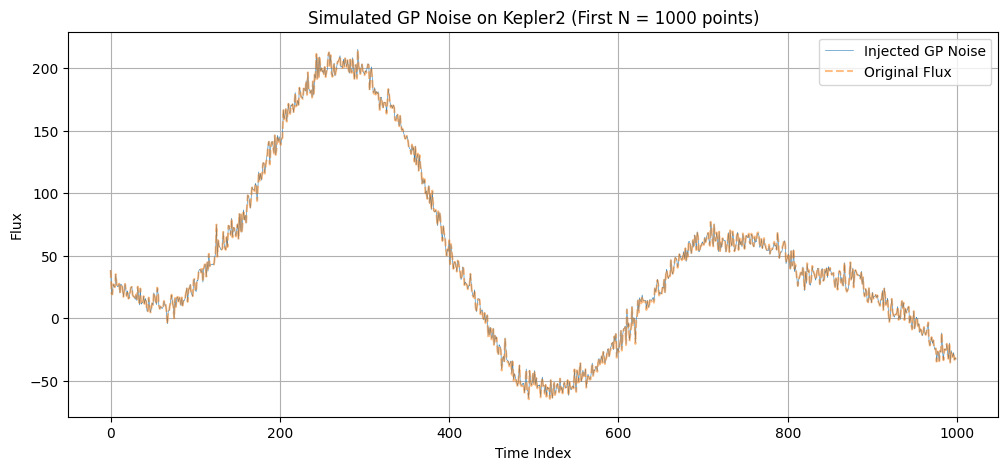

In [93]:
np.random.seed(442)

N = 1000
t2_sub = t2[:N]
flux2_sub = flux2_interp[:N]

cov2_sub = man_ExpSquaredKernel(t2_sub, A = 0.5, l = 50.0)
gp_noise_sub2 = np.random.multivariate_normal(mean=np.zeros(N), cov=cov2_sub)

# Add GP noise
flux_gp_injected2 = flux2_sub + gp_noise_sub2

plt.figure(figsize=(12, 5))
plt.plot(t2_sub, flux_gp_injected2, label='Injected GP Noise', lw = 0.4)
plt.plot(t2_sub, flux2_sub, '--', label='Original Flux', alpha=0.5)
plt.xlabel("Time Index")
plt.ylabel("Flux")
plt.legend()
plt.title("Simulated GP Noise on Kepler2 (First N = 1000 points)")
plt.grid(True)
plt.show()